In [40]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
import ast
from scipy.stats import kurtosis, skew
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

TABLA EARNINGS

In [2]:
calendar = pd.read_csv('earnings_weekly_expiration_table_full.csv')

In [3]:
def next_working_day(date):
    us_holidays = holidays.UnitedStates()
    next_day = date + timedelta(days=1)
    
    # Keep adding days until we find a weekday that is not a holiday
    while next_day.weekday() >= 5 or next_day in us_holidays:
        next_day += timedelta(days=1) 
    return next_day

In [4]:
calendar['earnings_date'] = pd.to_datetime(calendar['earnings_date'])
calendar['next_work_day'] = calendar['earnings_date'].apply(next_working_day)

In [5]:
# convertir el gap en absoluto
calendar['gap_strikes'] = calendar['gap_strikes'].abs()

In [6]:
calendar

,id,ticker_id,earnings_date,eps_estimate,reported_eps,surprise,dte,gap_strikes,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,ticker,strike_width,weekly_expiration,next_work_day
0,2,2,2025-06-10 20:00:00,0.00,0.00,0.0000,3,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-06-11 20:00:00
1,3,2,2025-03-05 10:00:00,0.00,0.00,0.0000,2,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-03-06 10:00:00
2,4,2,2024-12-05 21:00:00,0.00,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-12-06 21:00:00
3,5,2,2024-08-29 10:00:00,1.20,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-08-30 10:00:00
4,6,2,2024-06-12 20:00:00,10.84,10.96,0.0107,2,4.29,149.55,171.0,0.65,1.67,AVGO,5.0,1,2024-06-13 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,6507,554,2023-08-08 11:00:00,1.32,1.41,0.0719,9,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-08-09 11:00:00
6506,6508,554,2023-05-04 11:00:00,1.26,1.31,0.0389,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-05-05 11:00:00
6507,6509,554,2023-02-14 12:00:00,1.05,1.15,0.0990,2,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-02-15 12:00:00
6508,6510,554,2022-11-03 11:00:00,1.24,1.21,-0.0207,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2022-11-04 11:00:00


In [7]:
# Create the 'date' column based on the 'earnings_date' column
calendar['date'] = calendar['earnings_date'].apply(
    lambda x: x.date() - pd.Timedelta(days=1) if x.time() <= pd.Timestamp('13:00:00').time() else x.date()
)
#df_all_market_earnings['date'] = df_all_market_earnings['earnings_date'].dt.date

In [8]:
calendar.dtypes

id                               int64
ticker_id                        int64
earnings_date           datetime64[ns]
eps_estimate                   float64
reported_eps                   float64
surprise                       float64
dte                              int64
gap_strikes                    float64
gap_before_close               float64
gap_after_open                 float64
range_before_strikes           float64
range_after_strikes            float64
ticker                          object
strike_width                   float64
weekly_expiration                int64
next_work_day           datetime64[ns]
date                            object
dtype: object

TABLA TICKERS

In [9]:
volatiles = pd.read_csv('volatile_top_tickers_1.csv')
volatiles.head(10)

,ticker,mean_gap,std_dev_gap,var_gap,min_gap,max_gap,count,escalones_unit,strike_width
0,BKNG,24.28,22.40,501.75,0.7,63.0,8,"[45.4, 40.7, 11.7, 63.0, 5.4, 0.7, 14.2, 13.1]",5.0
1,SEDG,22.85,12.80,163.73,4.0,36.4,8,"[4.0, 14.4, 11.9, 35.0, 36.1, 15.7, 29.3, 36.4]",1.0
2,ENPH,19.45,11.49,132.13,0.9,42.0,8,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",1.0
3,EL,16.41,16.14,260.46,5.5,51.1,7,"[6.3, nan, 19.6, 10.1, 51.1, 7.1, 15.2, 5.5]",1.0
4,ALGN,14.75,8.21,67.47,3.2,25.6,8,"[4.5, 14.3, 22.7, 25.6, 13.0, 21.6, 13.1, 3.2]",2.5
5,DG,11.91,9.49,90.05,2.8,29.0,8,"[4.6, 7.9, 5.3, 29.0, 22.2, 2.8, 16.0, 7.5]",1.0
6,AAP,11.26,12.53,156.89,0.1,32.3,8,"[5.8, 1.0, 3.6, 0.1, 32.3, 4.2, 27.7, 15.4]",1.0
7,EXPE,11.22,8.05,64.76,4.8,28.9,8,"[13.8, 28.9, 13.2, 11.7, 5.2, 6.3, 5.9, 4.8]",1.0
8,DLTR,10.71,8.17,66.77,1.3,20.6,8,"[2.3, 20.5, 1.3, 11.2, 20.6, 2.0, 10.9, 16.9]",1.0
9,DELL,8.89,12.03,144.66,0.0,29.8,8,"[26.0, 29.8, 4.0, 7.7, 0.0, 1.1, 0.6, 1.9]",1.0


In [10]:
volatiles.dtypes

ticker             object
mean_gap          float64
std_dev_gap       float64
var_gap           float64
min_gap           float64
max_gap           float64
count               int64
escalones_unit     object
strike_width      float64
dtype: object

In [11]:
# Calcular percentiles específicos
percentiles = [0.25,0.75]  # Percentiles a calcular (25%, 50%, 75%)
percentile_values = volatiles['mean_gap'].quantile(percentiles)
percentile_values_35 = volatiles['mean_gap'].quantile(0.75)
# Mostrar los valores de los percentiles
print("Percentiles de 'mean_gap':")
print(percentile_values)
print(percentile_values_35)

Percentiles de 'mean_gap':
0.25    0.54
0.75    2.17
Name: mean_gap, dtype: float64
2.17


In [12]:
# Function to clean and convert the string representation of lists
def clean_and_convert(series_str):
    try:
        # Use regular expression to find all float numbers in the string
        clean_str = re.findall(r"[-+]?\d*\.\d+|\d+", series_str)
        # Convert the list of strings to a list of floats
        clean_list = [float(num) for num in clean_str]
        return clean_list
    except Exception as e:
        return np.nan

# Define a function to calculate the mean of a list, ignoring NaNs
def calculate_mean(series_list):
    if isinstance(series_list, list):
        return np.nanmean(series_list)
    else:
        return np.nan

# Define a function to calculate the kurtosis of a list, ignoring NaNs
def calculate_kurtosis(series_list):
    if isinstance(series_list, list) and len(series_list) > 0:
        return kurtosis(series_list, nan_policy='omit')
    else:
        return np.nan

# Define a function to calculate the skewness of a list, ignoring NaNs
def calculate_skewness(series_list):
    if isinstance(series_list, list) and len(series_list) > 0:
        return skew(series_list, nan_policy='omit')
    else:
        return np.nan

# Apply the cleaning, mean calculation, kurtosis calculation, and skewness calculation functions
#volatiles['media_list'] = volatiles['escalones_unit'].apply(lambda x: calculate_mean(clean_and_convert(x)))
volatiles['kurtos'] = volatiles['escalones_unit'].apply(lambda x: calculate_kurtosis(clean_and_convert(x)))
volatiles['skew'] = volatiles['escalones_unit'].apply(lambda x: calculate_skewness(clean_and_convert(x)))

volatiles['kurtos'] = round(volatiles['kurtos'],2)
volatiles['skew'] = round(volatiles['skew'],2)

In [13]:
ordered_columns = [
    'ticker',
    'strike_width',
    'mean_gap',
    'kurtos',
    'skew',
    'std_dev_gap',
    'var_gap',
    'min_gap',
    'max_gap',
    'count',
    'escalones_unit'
]
volatiles = volatiles[ordered_columns]

El Gap medio es de: 2.04 escalones


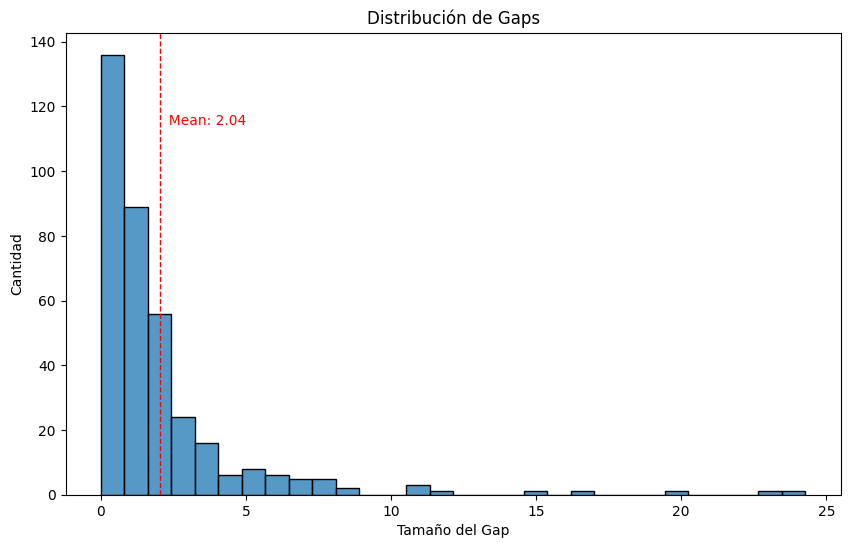

In [14]:
# Assuming your DataFrame is named df and the column is named 'mean_gap'
# Calculate the mean of the 'mean_gap' column
mean_value = volatiles['mean_gap'].mean()
mean_value = round(mean_value,2)
print(f"El Gap medio es de: {mean_value} escalones")
# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(volatiles['mean_gap'], bins=30)

# Plot a vertical line at the mean value
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)

# Add text annotation for the mean value
plt.text(mean_value, plt.ylim()[1]*0.8, f'  Mean: {mean_value:.2f}', color='red')

# Titles and labels
plt.title('Distribución de Gaps')
plt.xlabel('Tamaño del Gap')
plt.ylabel('Cantidad')

# Show plot
plt.show()

In [15]:
def analyze_mean_gap(df, column_name):
    # Ensure the column is numeric and drop missing values
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df = df.dropna(subset=[column_name])
    
    mean_value = df[column_name].mean()
    count_above_mean = df[df[column_name] > mean_value].shape[0]
    skewness_value = skew(df[column_name])
    kurtosis_value = kurtosis(df[column_name])
    
    # Number of rows in the DataFrame
    num_tickers = df.shape[0]
    
    print(f"Número de tickers: {num_tickers}")
    print(f"Mean of '{column_name}': {mean_value:.2f}")
    print(f"Number of rows with '{column_name}' above the mean: {count_above_mean}")
    print(f"Skewness of '{column_name}': {skewness_value:.2f}")
    print(f"Kurtosis of '{column_name}' (leptokurtic if >3): {kurtosis_value:.2f}")

    # Return the results in a dictionary
    return {
        "mean": mean_value,
        "count_above_mean": count_above_mean,
        "skewness": skewness_value,
        "kurtosis": kurtosis_value,
        "num_tickers": num_tickers
    }

In [16]:
resultados_estadísticos = analyze_mean_gap(volatiles, 'mean_gap')

# Calculate Q1 (25th percentile) and Q4 (75th percentile)
Q1 = volatiles['mean_gap'].quantile(0.25)
Q4 = volatiles['mean_gap'].quantile(0.75)
print(f"Q1 - Low Quantile 25% : {Q1}")
print(f"Q4 - Low Quantile 75% : {Q4}")

Número de tickers: 362
Mean of 'mean_gap': 2.04
Number of rows with 'mean_gap' above the mean: 102
Skewness of 'mean_gap': 4.13
Kurtosis of 'mean_gap' (leptokurtic if >3): 22.69
Q1 - Low Quantile 25% : 0.54
Q4 - Low Quantile 75% : 2.17


In [17]:
volatiles.loc[volatiles['mean_gap'] < Q1, 'tag'] = 'mamut'
volatiles.loc[volatiles['mean_gap'] > Q4, 'tag'] = 'gacela'
volatiles

,ticker,strike_width,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,escalones_unit,tag
0,BKNG,5.0,24.28,-1.05,0.65,22.40,501.75,0.7,63.0,8,"[45.4, 40.7, 11.7, 63.0, 5.4, 0.7, 14.2, 13.1]",gacela
1,SEDG,1.0,22.85,-1.56,-0.15,12.80,163.73,4.0,36.4,8,"[4.0, 14.4, 11.9, 35.0, 36.1, 15.7, 29.3, 36.4]",gacela
2,ENPH,1.0,19.45,0.55,0.51,11.49,132.13,0.9,42.0,8,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",gacela
3,EL,1.0,16.41,1.25,1.64,16.14,260.46,5.5,51.1,7,"[6.3, nan, 19.6, 10.1, 51.1, 7.1, 15.2, 5.5]",gacela
4,ALGN,2.5,14.75,-1.25,-0.15,8.21,67.47,3.2,25.6,8,"[4.5, 14.3, 22.7, 25.6, 13.0, 21.6, 13.1, 3.2]",gacela
...,...,...,...,...,...,...,...,...,...,...,...,...
541,XYL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN
542,YUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN
543,ZBH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN
544,ZBRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN


In [18]:
volatiles.to_csv('filled_tickers_stats_summary.csv', index=False)

CONSTRUCCIÓN DE LA TABLA COMPLETA DE LOS EARNINGS

In [19]:
df = calendar.merge(volatiles, on='ticker', how='left')
df.rename(columns={'strike_width_x': 'strike_width'}, inplace=True)
df= df.rename(columns={'date': 'to_open_day'})
df['surprise'] =  round(df['surprise'],2)
df['next_work_day'] = df['next_work_day'].dt.date

df.loc[df['gap_strikes'] < Q1, 'evento'] = 'cisne_blanco'
df.loc[df['gap_strikes'] > Q4, 'evento'] = 'cisne_negro'

column_order = [
    'ticker_id', 'ticker', 'tag', 'earnings_date', 'to_open_day', 'dte', 'escalones_unit', 'mean_gap', 
    'kurtos', 'skew', 'std_dev_gap', 'var_gap', 'min_gap', 'max_gap', 'count','eps_estimate', 'reported_eps', 
    'surprise',  'gap_strikes','evento', 'gap_before_close', 'gap_after_open', 
    'range_before_strikes', 'range_after_strikes', 
    'weekly_expiration', 'next_work_day'
]
df = df[column_order]

In [29]:
df = df.sort_values(by='ticker_id')
df = df.reset_index(drop=True)
df

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,weekly_expiration,next_work_day
0,2,AVGO,NaN,2025-06-10 20:00:00,2025-06-10,3,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,2025-06-11
1,2,AVGO,NaN,2024-03-07 21:00:00,2024-03-07,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,10.29,10.99,0.07,0.31,cisne_blanco,139.72,138.2,0.59,2.23,1,2024-03-08
2,2,AVGO,NaN,2025-03-05 10:00:00,2025-03-04,2,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,2025-03-06
3,2,AVGO,NaN,2024-12-05 21:00:00,2024-12-05,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-12-06
4,2,AVGO,NaN,2024-06-12 20:00:00,2024-06-12,2,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,10.84,10.96,0.01,4.29,cisne_negro,149.55,171.0,0.65,1.67,1,2024-06-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,554,ZTS,NaN,2023-05-04 11:00:00,2023-05-03,14,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.26,1.31,0.04,NaN,NaN,NaN,NaN,NaN,NaN,0,2023-05-05
6506,554,ZTS,NaN,2023-02-14 12:00:00,2023-02-13,2,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.05,1.15,0.10,NaN,NaN,NaN,NaN,NaN,NaN,0,2023-02-15
6507,554,ZTS,NaN,2024-05-02 11:00:00,2024-05-01,14,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.34,1.38,0.03,NaN,NaN,NaN,NaN,NaN,NaN,0,2024-05-03
6508,554,ZTS,NaN,2024-02-13 12:00:00,2024-02-12,2,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.32,1.24,-0.06,NaN,NaN,NaN,NaN,NaN,NaN,0,2024-02-14


In [21]:
df.to_csv('calendario_earnings_con_todos_las_columnas_full.csv', index=False)

ESTADÍSTICAS POR VALOR

In [22]:
df_cat = df[df['ticker'] == 'CAT']
df_cat

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,weekly_expiration,next_work_day
359,31,CAT,gacela,2022-08-02 10:00:00,2022-08-01,3,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,3.01,3.18,0.06,NaN,NaN,NaN,NaN,NaN,NaN,1,2022-08-03
358,31,CAT,gacela,2022-10-27 10:00:00,2022-10-26,1,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,3.16,3.95,0.25,NaN,NaN,NaN,NaN,NaN,NaN,1,2022-10-28
357,31,CAT,gacela,2023-01-31 11:00:00,2023-01-30,3,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,4.02,4.27,0.06,1.37,NaN,262.44,255.58,0.61,3.25,1,2023-02-01
356,31,CAT,gacela,2023-04-27 10:00:00,2023-04-26,1,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,3.78,4.91,0.30,1.14,NaN,216.19,210.48,0.85,2.41,1,2023-04-28
355,31,CAT,gacela,2023-08-01 10:00:00,2023-07-31,3,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,4.58,5.55,0.21,NaN,NaN,NaN,NaN,NaN,NaN,1,2023-08-02
354,31,CAT,gacela,2023-10-31 10:00:00,2023-10-30,3,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,4.79,5.52,0.15,2.90,cisne_negro,242.16,227.65,0.88,1.36,1,2023-11-01
353,31,CAT,gacela,2024-02-05 11:00:00,2024-02-04,4,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,4.75,5.23,0.10,2.68,cisne_negro,316.11,329.50,2.23,4.22,1,2024-02-06
352,31,CAT,gacela,2024-04-25 10:00:00,2024-04-24,1,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,5.14,5.60,0.09,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-04-26
351,31,CAT,gacela,2024-07-30 10:00:00,2024-07-29,3,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,5.54,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31
350,31,CAT,gacela,2024-10-29 10:00:00,2024-10-28,3,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.0,3.98,0.9,6.6,7.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-10-30


ACCIONES A TRADEAR UN DIA DETERMINADO

In [23]:
fecha = '2024-07-29'

# Convert the date string to a datetime object
date_to_find = pd.to_datetime(fecha)

# Filter the DataFrame for the specified date and where weekly_expiration is 1
tickes_to_trade = df[(df['to_open_day'] == date_to_find) & (df['weekly_expiration'] == 1)]

# Sort the filtered DataFrame by 'mean_gap' in descending order
tickes_to_trade_sorted = tickes_to_trade.sort_values(by='mean_gap', ascending=False)

tickes_to_trade_sorted = tickes_to_trade_sorted.reset_index(drop=True)

In [24]:
tickes_to_trade

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,weekly_expiration,next_work_day
351,31,CAT,gacela,2024-07-30 10:00:00,2024-07-29,3,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",2.41,0.89,1.49,2.00,3.98,0.9,6.6,7.0,5.54,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31
627,54,PFE,mamut,2024-07-30 12:00:00,2024-07-29,3,"[0.7, 0.4, 0.2, 0.2, 0.1, 0.5, 1.3, 0.6]",0.50,0.35,1.07,0.39,0.15,0.1,1.3,8.0,0.46,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31
1457,123,MRK,NaN,2024-07-30 12:00:00,2024-07-29,3,"[2.7, 2.8, 0.5, 2.9, 1.1, 2.8]",2.13,-1.22,-0.80,1.05,1.11,0.5,2.9,6.0,2.15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31
1947,164,ADM,NaN,2024-07-30 12:00:00,2024-07-29,3,"[0.1, 2.2, 0.7, 0.1, 2.3, 0.5, 1.0, 2.7]",1.20,-1.53,0.34,1.05,1.09,0.1,2.7,8.0,1.22,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31
2807,238,GLW,gacela,2024-07-30 12:00:00,2024-07-29,3,"[2.7, 3.3, 2.7, 1.0, 0.7, 0.0, 5.0]",2.20,-1.00,0.27,1.74,3.01,0.0,5.0,7.0,0.46,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31
5165,440,PSX,NaN,2024-07-30 12:00:00,2024-07-29,3,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.98,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31
5249,447,PG,NaN,2024-07-30 12:00:00,2024-07-29,3,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.37,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31
5522,470,SPGI,NaN,2024-07-30 12:00:00,2024-07-29,3,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.61,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31


FILTRADO DE LA DATA

In [25]:
# Mamuts
mamuts = volatiles[volatiles['tag'] == 'mamut']
mamuts

,ticker,strike_width,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,escalones_unit,tag
275,CINF,5.0,0.51,-1.31,0.01,0.41,0.17,0.0,1.1,8,"[0.0, 0.8, 0.4, 1.1, 0.6, 0.3, 0.0, 0.9]",mamut
276,ITW,10.0,0.51,-1.51,-0.23,0.36,0.13,0.0,0.9,8,"[0.1, 0.7, 0.3, 0.8, 0.9, 0.9, 0.0, 0.4]",mamut
277,PFE,1.0,0.50,0.35,1.07,0.39,0.15,0.1,1.3,8,"[0.7, 0.4, 0.2, 0.2, 0.1, 0.5, 1.3, 0.6]",mamut
278,DAY,5.0,0.50,-2.00,0.00,0.14,0.02,0.4,0.6,2,"[0.4, 0.6]",mamut
279,KAI,10.0,0.50,0.02,0.90,0.45,0.20,0.0,1.4,8,"[1.4, 0.8, 0.2, 0.4, 0.1, 0.0, 0.6, 0.5]",mamut
...,...,...,...,...,...,...,...,...,...,...,...,...
357,CMS,5.0,0.05,-2.00,0.00,0.05,0.00,0.0,0.1,8,"[0.1, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0]",mamut
358,AEE,5.0,0.04,0.86,1.56,0.07,0.01,0.0,0.2,8,"[0.0, 0.0, 0.2, 0.0, 0.0, 0.1, 0.0, 0.0]",mamut
359,DOC,2.5,0.04,-1.68,0.57,0.05,0.00,0.0,0.1,11,"[0.1, 0.0, nan, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, ...",mamut
360,GFI,1.0,0.00,NaN,NaN,NaN,NaN,0.0,0.0,1,[0.0],mamut


In [28]:
# Mamuts
gacelas = volatiles[volatiles['tag'] == 'gacela']
gacelas

,ticker,strike_width,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,escalones_unit,tag
0,BKNG,5.0,24.28,-1.05,0.65,22.40,501.75,0.7,63.0,8,"[45.4, 40.7, 11.7, 63.0, 5.4, 0.7, 14.2, 13.1]",gacela
1,SEDG,1.0,22.85,-1.56,-0.15,12.80,163.73,4.0,36.4,8,"[4.0, 14.4, 11.9, 35.0, 36.1, 15.7, 29.3, 36.4]",gacela
2,ENPH,1.0,19.45,0.55,0.51,11.49,132.13,0.9,42.0,8,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",gacela
3,EL,1.0,16.41,1.25,1.64,16.14,260.46,5.5,51.1,7,"[6.3, nan, 19.6, 10.1, 51.1, 7.1, 15.2, 5.5]",gacela
4,ALGN,2.5,14.75,-1.25,-0.15,8.21,67.47,3.2,25.6,8,"[4.5, 14.3, 22.7, 25.6, 13.0, 21.6, 13.1, 3.2]",gacela
...,...,...,...,...,...,...,...,...,...,...,...,...
85,CZR,0.5,2.34,-0.18,1.10,1.76,3.11,0.9,5.8,8,"[1.0, 4.2, 2.0, 2.0, 1.9, 0.9, 5.8, 0.9]",gacela
86,TGT,5.0,2.29,-0.47,0.54,1.78,3.16,0.2,5.6,8,"[3.0, 3.1, 3.0, 1.9, 0.2, 0.4, 5.6, 1.1]",gacela
87,EBAY,1.0,2.26,-0.78,-0.40,1.05,1.10,0.4,3.5,8,"[1.7, 3.3, 3.5, 3.2, 1.8, 2.4, 1.8, 0.4]",gacela
88,AXP,2.5,2.24,-0.78,0.17,1.27,1.61,0.5,4.4,9,"[3.0, 0.5, 1.8, 2.0, 2.0, 2.4, 4.4, 0.6, 3.5]",gacela


In [30]:
# Cisnes Negros
cisnes_negros = df[df['evento'] == 'cisne_negro']
cisnes_negros

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,weekly_expiration,next_work_day
4,2,AVGO,NaN,2024-06-12 20:00:00,2024-06-12,2,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.84,10.96,0.01,4.29,cisne_negro,149.55,171.00,0.65,1.67,1,2024-06-13
13,3,COST,NaN,2024-03-07 21:00:00,2024-03-07,1,"[0.6, 2.9, 1.0, 0.5, 0.1, 1.1, 0.6, 0.8]",0.95,1.78,1.67,0.85,0.72,0.1,2.9,8.0,3.62,3.92,0.08,3.11,cisne_negro,784.57,753.50,1.01,3.66,1,2024-03-08
24,4,DECK,gacela,2024-05-23 20:00:00,2024-05-23,28,"[22.1, 12.6, 12.1, 3.8, 3.0, 1.2, 2.6, 4.3]",7.71,-0.21,1.03,7.25,52.55,1.2,22.1,8.0,2.89,4.95,0.71,22.05,cisne_negro,904.65,1014.92,9.31,8.50,0,2024-05-24
25,4,DECK,gacela,2024-02-01 21:00:00,2024-02-01,14,"[22.1, 12.6, 12.1, 3.8, 3.0, 1.2, 2.6, 4.3]",7.71,-0.21,1.03,7.25,52.55,1.2,22.1,8.0,11.48,15.11,0.32,14.16,cisne_negro,774.18,845.00,4.14,14.96,0,2024-02-02
31,4,DECK,gacela,2023-05-25 20:00:00,2023-05-25,21,"[22.1, 12.6, 12.1, 3.8, 3.0, 1.2, 2.6, 4.3]",7.71,-0.21,1.03,7.25,52.55,1.2,22.1,8.0,2.67,3.46,0.30,3.00,cisne_negro,450.01,435.01,3.77,9.57,0,2023-05-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,350,ISRG,gacela,2024-07-18 20:00:00,2024-07-18,1,"[6.7, 2.5, 2.5, 2.7, 2.4, 4.5, 3.4, 4.8]",3.69,-0.30,0.96,1.54,2.36,2.4,6.7,8.0,1.54,1.78,0.16,6.66,cisne_negro,416.14,449.43,6.24,3.56,1,2024-07-19
4174,356,JKHY,NaN,2023-08-15 20:00:00,2023-08-15,2,"[0.2, 0.5, 2.7, 3.1, 0.3, 2.9, 2.3, 2.2]",1.78,-1.65,-0.36,1.23,1.52,0.2,3.1,8.0,1.18,1.34,0.13,3.06,cisne_negro,168.31,152.99,0.82,1.98,0,2023-08-16
4186,357,JNPR,NaN,2023-10-26 20:00:00,2023-10-26,21,"[0.1, 0.2, 0.0, 2.8, 1.0, 2.4, 1.9, 0.8]",1.15,-1.39,0.39,1.09,1.19,0.0,2.8,8.0,0.55,0.60,0.10,2.76,cisne_negro,25.08,27.84,0.52,2.32,0,2023-10-27
4289,366,KLAC,gacela,2023-04-26 20:00:00,2023-04-26,2,"[2.0, 3.5, 0.8, 3.5, 5.3, 4.8, 1.9, 1.6]",2.92,-1.28,0.24,1.60,2.57,0.8,5.3,8.0,5.32,5.49,0.03,5.28,cisne_negro,357.36,383.75,2.70,3.36,1,2023-04-27


In [31]:
# Cisnes Negros
cisnes_negros = df[df['evento'] == 'cisne_blanco']
cisnes_negros

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,weekly_expiration,next_work_day
1,2,AVGO,NaN,2024-03-07 21:00:00,2024-03-07,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.29,10.99,0.07,0.31,cisne_blanco,139.72,138.20,0.59,2.23,1,2024-03-08
5,2,AVGO,NaN,2023-06-01 20:00:00,2023-06-01,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.08,10.32,0.02,0.01,cisne_blanco,79.00,79.06,0.41,0.73,1,2023-06-02
7,2,AVGO,NaN,2023-08-31 20:00:00,2023-08-31,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.42,10.54,0.01,0.42,cisne_blanco,92.29,90.19,0.79,0.74,1,2023-09-01
8,2,AVGO,NaN,2023-03-02 21:00:00,2023-03-02,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.10,10.33,0.02,0.23,cisne_blanco,59.58,60.75,0.22,0.55,1,2023-03-03
11,2,AVGO,NaN,2023-12-07 21:00:00,2023-12-07,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.98,11.06,0.01,0.04,cisne_blanco,92.10,92.28,0.41,0.56,1,2023-12-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,362,KEYS,gacela,2023-11-20 21:00:00,2023-11-20,24,"[1.3, 2.8, 0.5, 4.3, 2.7, 4.5, 1.2, 1.5]",2.35,-1.26,0.37,1.48,2.19,0.5,4.5,8.0,1.87,1.99,0.06,0.05,cisne_blanco,135.46,135.21,0.57,0.99,0,2023-11-21
4256,363,KMB,gacela,2023-07-25 11:00:00,2023-07-24,3,"[10.0, 5.2, 0.7, 0.4, 2.4, 5.1, 0.8, 3.5]",3.51,-0.05,0.93,3.24,10.52,0.4,10.0,8.0,1.48,1.65,0.11,0.39,cisne_blanco,137.17,136.78,1.59,5.56,1,2023-07-26
4257,364,KIM,mamut,2023-07-27 10:00:00,2023-07-26,21,"[0.1, 0.0, 0.1, 0.1, 0.0, 0.1, 0.2, 0.1, 0.1, ...",0.10,2.27,1.59,0.11,0.01,0.0,0.4,12.0,0.17,0.16,-0.07,0.13,cisne_blanco,20.73,21.05,0.10,0.38,0,2023-07-28
4261,364,KIM,mamut,2023-04-27 10:00:00,2023-04-26,21,"[0.1, 0.0, 0.1, 0.1, 0.0, 0.1, 0.2, 0.1, 0.1, ...",0.10,2.27,1.59,0.11,0.01,0.0,0.4,12.0,0.20,0.46,1.27,0.04,cisne_blanco,18.66,18.75,0.15,0.21,0,2023-04-28


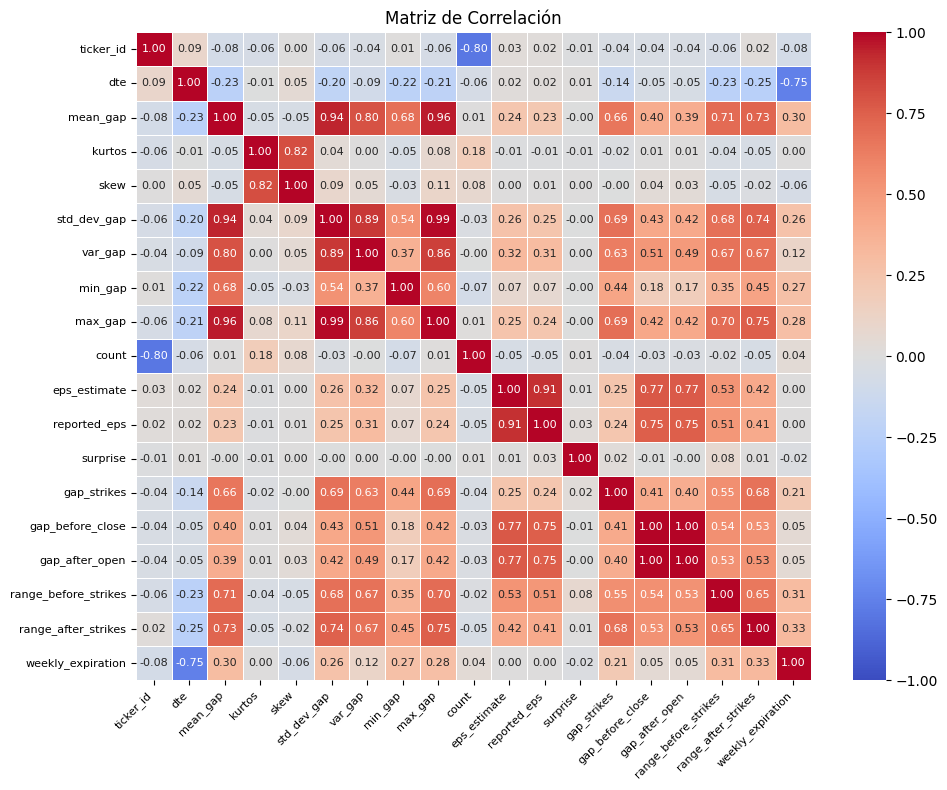

In [34]:
corr_matrix = df.corr()

# Crear el gráfico de mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5, 
            annot_kws={"size": 8},  # Tamaño de las anotaciones
            fmt='.2f')  # Formato de los números

# Ajustar el tamaño de las etiquetas de los ejes
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.title('Matriz de Correlación', fontsize=12)
plt.tight_layout()  # Ajusta el diseño para que se ajuste a la figura
plt.show()

In [41]:
# Count occurrences of 'mamut' in 'tag' and 'cisne blanco' in 'evento'
count_mamut_cisne_blanco = df[(df['tag'] == 'mamut') & (df['evento'] == 'cisne_blanco')].shape[0]

# Count occurrences of 'cisne negro' in 'tag' and 'gacela' in 'evento'
count_cisne_negro_gacela = df[(df['tag'] == 'gacela') & (df['evento'] == 'cisne_negro')].shape[0]

print(f"Number of occurrences where 'tag' is 'mamut' and 'evento' is 'cisne blanco': {count_mamut_cisne_blanco}")
print(f"Number of occurrences where 'tag' is 'cisne negro' and 'evento' is 'gacela': {count_cisne_negro_gacela}")

Number of occurrences where 'tag' is 'mamut' and 'evento' is 'cisne blanco': 127
Number of occurrences where 'tag' is 'cisne negro' and 'evento' is 'gacela': 124


In [45]:
# Count occurrences of each combination
count_mamut_cisne_blanco = df[(df['tag'] == 'mamut') & (df['evento'] == 'cisne_blanco')].shape[0]
count_cisne_negro_gacela = df[(df['tag'] == 'gacela') & (df['evento'] == 'cisne_negro')].shape[0]

# Creating a contingency table
contingency_table = pd.DataFrame({
    'cisne blanco': [count_mamut_cisne_blanco, 0],
    'cisne negro': [0, count_cisne_negro_gacela]
}, index=['mamut', 'gacela'])

print("Contingency Table:")
print(contingency_table)

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test Statistic: {chi2:.2f}")
print(f"P-Value: {p:.2f}")   # POR DEBAJO DE 0.05 ES SIGNIFCANTE
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

# Interpretation
if p < 0.05:
    print("There is a significant association between the categories.")
else:
    print("There is no significant association between the categories.")

Contingency Table:
        cisne blanco  cisne negro
mamut            127            0
gacela             0          124
Chi-Square Test Statistic: 247.02
P-Value: 0.00
Degrees of Freedom: 1
Expected Frequencies:
[[64.25896414 62.74103586]
 [62.74103586 61.25896414]]
There is a significant association between the categories.


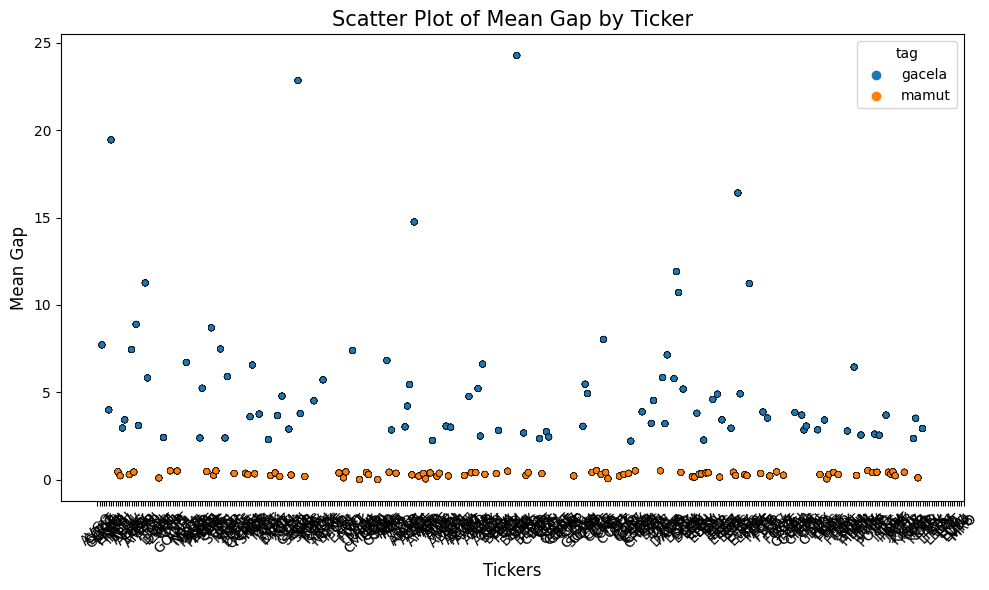

In [55]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ticker', y='mean_gap', hue='tag',s=20, color='blue', edgecolor='black')

# Customize plot
plt.title('Scatter Plot of Mean Gap by Ticker', fontsize=15)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Mean Gap', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.tight_layout()
plt.show()

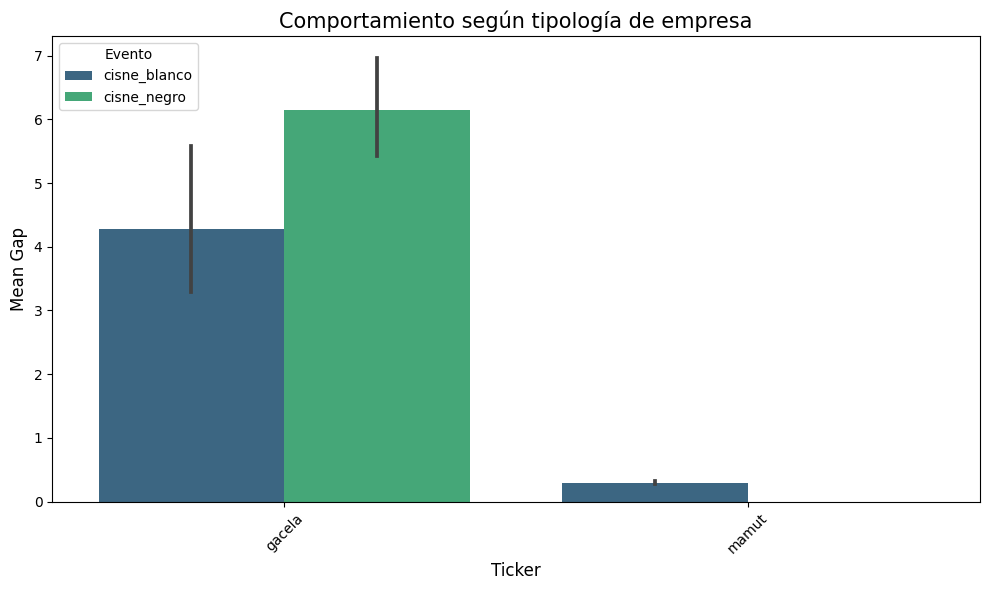

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='tag', y='mean_gap', hue='evento', palette='viridis')

# Customize plot
plt.title('Comportamiento según tipología de empresa', fontsize=15)
plt.xlabel('Ticker', fontsize=12)
plt.ylabel('Mean Gap', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show legend
plt.legend(title='Evento')

# Show plot
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """Calculate the Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type")
    
    return price

def implied_volatility(S, K, T, r, market_price, option_type='call'):
    """Calculate the implied volatility using numerical methods."""
    
    # Objective function to minimize
    def objective_function(sigma):
        return (black_scholes_price(S, K, T, r, sigma, option_type) - market_price) ** 2
    
    # Initial guess for volatility
    initial_guess = 0.2
    
    # Use minimize function to find implied volatility
    result = minimize(objective_function, initial_guess, bounds=[(0.001, None)])
    
    
    return result.x[0]

# Example usage
S = 108  # Current stock price
K = 103  # Strike price
T = 0.004  # Time to expiration in years
r = 0.04  # Risk-free interest rate
market_price = 2.65  # Market price of the option
option_type = 'put'  # Option type ('call' or 'put')

# Calculate implied volatility
volatility = implied_volatility(S, K, T, r, market_price, option_type)
volatility = round(volatility *100,2)
print(f"Implied Volatility: {volatility:.2f} %")


Implied Volatility: 178.29 %
